# Database Connection Setup
This section establishes a connection to a database using environment variables.
It loads credentials from a `.env` file and creates a connection using SQLAlchemy.

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Fetch database connection details from the environment
db_server = os.getenv('DB_SERVER')
db_database = os.getenv('DB_DATABASE')

# Ensure the environment variables are set
if not db_server or not db_database:
    raise ValueError("DB_SERVER or DB_DATABASE environment variable is missing")

# Create the connection string for Windows Authentication
connection_string = (
    "mssql+pyodbc:///?odbc_connect="
    f"Driver={{ODBC Driver 17 for SQL Server}};"
    f"Server={db_server};"
    f"Database={db_database};"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)

try:
    # Create the engine
    engine = create_engine(connection_string)

    # SQL queries to fetch data from the views
    query1 = 'SELECT * FROM dbo.vw_ChurnData'
    query2 = 'SELECT * FROM dbo.vw_Join_Data'

    # Fetch data from the first query (ChurnData)
    with engine.connect() as connection:
        result1 = connection.execute(text(query1))
        data1 = result1.fetchall()
        df1 = pd.DataFrame(data1, columns=result1.keys())

    # Fetch data from the second query (Join_Data)
    with engine.connect() as connection:
        result2 = connection.execute(text(query2))
        data2 = result2.fetchall()
        df2 = pd.DataFrame(data2, columns=result2.keys())

    # Optionally, print the first few rows to verify
    print("Data from the first query (ChurnData):")
    print(df1.head())
    print("\nData from the second query (Join_Data):")
    print(df2.head())

    # Save both DataFrames to CSV files
    df1.to_csv('train_data.csv', index=False)
    df2.to_csv('test_data.csv', index=False)

except Exception as e:
    print(f"An error occurred: {e}")


Data from the first query (ChurnData):
  Customer_ID  Gender  Age Married           State  Number_of_Referrals  \
0   12728-AND  Female   28     Yes  Andhra Pradesh                    2   
1   12736-ASS  Female   62      No           Assam                   10   
2   12739-HAR    Male   57     Yes         Haryana                    1   
3   12746-WES    Male   53      No     West Bengal                    7   
4   12752-RAJ  Female   30      No       Rajasthan                    4   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                13       None           Yes            Yes  ...   
1                 3       None           Yes             No  ...   
2                31       None           Yes            Yes  ...   
3                17       None           Yes             No  ...   
4                17       None           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0      Credit Card      80.300003   

# Machine Learning Model Training
This section prepares a dataset for machine learning using pandas, sklearn.model_selection, sklearn.preprocessing, and classifiers.
It performs data preprocessing, encoding, scaling, and splitting before training models (RandomForestClassifier, LogisticRegression).

Confusion matrix for rf:
[[1177   78]
 [ 195  353]]
Confusion matrix for lr:
[[1117  138]
 [ 198  350]]
Random Forest Model Performance:

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1255
           1       0.82      0.64      0.72       548

    accuracy                           0.85      1803
   macro avg       0.84      0.79      0.81      1803
weighted avg       0.85      0.85      0.84      1803

Accuracy: 0.848585690515807

Logistic Regression Model Performance:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1255
           1       0.72      0.64      0.68       548

    accuracy                           0.81      1803
   macro avg       0.78      0.76      0.77      1803
weighted avg       0.81      0.81      0.81      1803

Accuracy: 0.8136439267886856


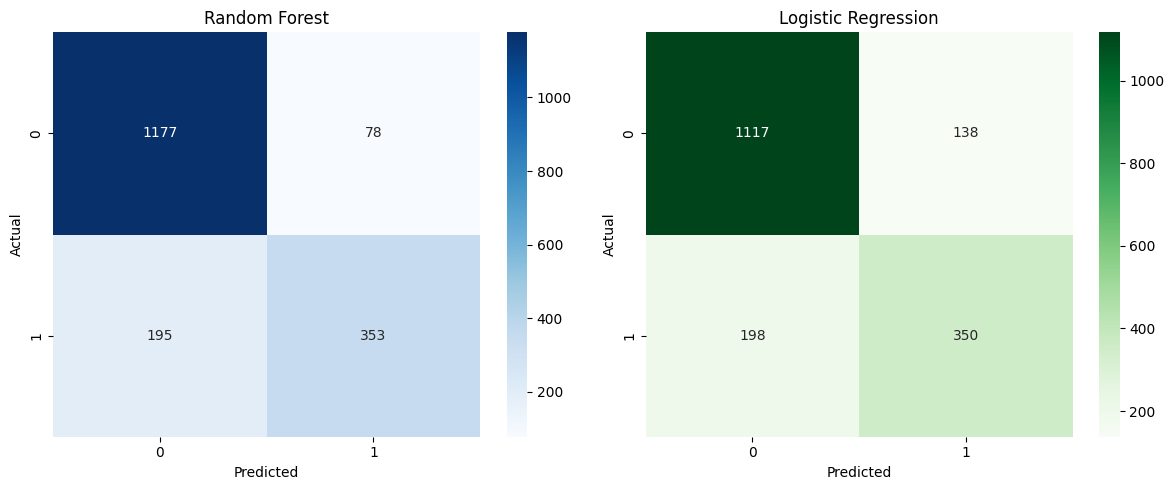

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder

# Load the data
data = pd.read_csv('train_data.csv')

def preprocess_data(data):
    # Dropping columns that are not valuable for model evaluation
    drop_columns = ['Customer_ID', 'State', 'Churn_Category', 'Churn_Reason', 'Value_Deal', 'Total_Refunds']
    data = data.drop(columns=[col for col in drop_columns if col in data.columns])
    
    # Filling missing values
    #data.fillna({'Internet_Type': 'None'}, inplace=True)
    
    # Manually encoding the target variable
    data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})
    
    categorical_columns2 = ['Gender', 'Married', 'Internet_Type', 'Contract', 'Payment_Method', 'Phone_Service', 
                           'Multiple_Lines', 'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 
                           'Premium_Support', 'Streaming_TV', 'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 
                           'Paperless_Billing','Internet_Service']

    # Encoding categorical variables
    label_encoders = {}
    for column in categorical_columns2:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])
    
    # Splitting features and target
    X = data.drop('Customer_Status', axis=1)
    y = data['Customer_Status']
    
    return X, y

X, y = preprocess_data(data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

# Training Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)

# Evaluation
print("Confusion matrix for rf:")
print(confusion_matrix(y_test,rf_y_pred))
print("Confusion matrix for lr:")
print(confusion_matrix(y_test,lr_y_pred))


print("Random Forest Model Performance:\n")
print(classification_report(y_test, rf_y_pred))
print("Accuracy:", accuracy_score(y_test, rf_y_pred))

print("\nLogistic Regression Model Performance:\n")
print(classification_report(y_test, lr_y_pred))
print("Accuracy:", accuracy_score(y_test, lr_y_pred))

# Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Random Forest')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(confusion_matrix(y_test, lr_y_pred), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Logistic Regression')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature Importance Analysis
This section extracts and analyzes feature importance from a trained Random Forest model.
It helps in understanding which features contribute most to predictions.

                        Feature  Importance
24                Total_Revenue    0.157708
17                     Contract    0.136184
21                Total_Charges    0.128115
20               Monthly_Charge    0.098415
23  Total_Long_Distance_Charges    0.091420
1                           Age    0.075248
4              Tenure_in_Months    0.053459
3           Number_of_Referrals    0.043266
8                 Internet_Type    0.026412
12              Premium_Support    0.021106
19               Payment_Method    0.019909
18            Paperless_Billing    0.015665
7              Internet_Service    0.014621
9               Online_Security    0.013945
22     Total_Extra_Data_Charges    0.011653
0                        Gender    0.011487
2                       Married    0.011161
11       Device_Protection_Plan    0.010768
10                Online_Backup    0.010563
6                Multiple_Lines    0.010556
15              Streaming_Music    0.010282
13                 Streaming_TV 

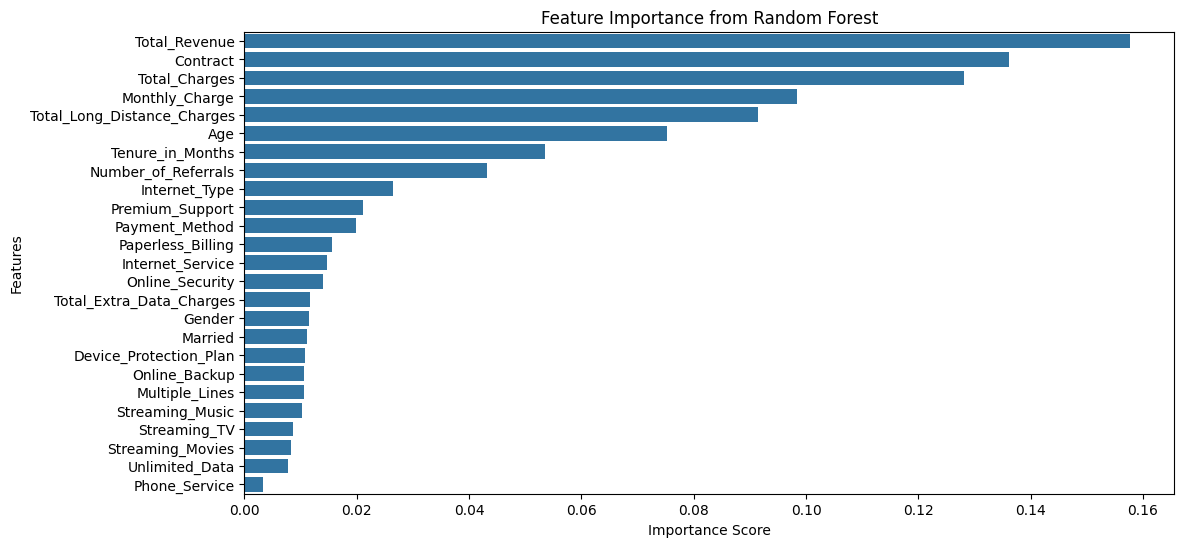

In [3]:
# Get feature importances from the trained Random Forest model
feature_importance = rf_model.feature_importances_

# Create a DataFrame to store feature names and their importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print top features
print(feature_importance_df)


# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'])
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


# Processing New Test Data
This section loads new test data from a CSV file.
It applies preprocessing and encoding while preserving original values.
Uses LabelEncoder for categorical encoding.
Retains Customer_ID for reference.

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load new test data
test_data = pd.read_csv('test_data.csv')

# Retain the original DataFrame to preserve unencoded columns
original_data = test_data.copy()

# Retain Customer_ID for reference
customer_ids = test_data['Customer_ID'] if 'Customer_ID' in test_data.columns else None

# Drop columns not used for model prediction
drop_columns = ['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason', 'Value_Deal', 'Total_Refunds', 'State']
test_data = test_data.drop(columns=[col for col in drop_columns if col in test_data.columns], errors='ignore')

# Define categorical columns
categorical_columns = ['Gender', 'Married', 'Internet_Type', 'Contract', 'Payment_Method', 'Phone_Service', 
                       'Multiple_Lines', 'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 
                       'Premium_Support', 'Streaming_TV', 'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 
                       'Paperless_Billing', 'Internet_Service']

# Ensure test data has same categorical columns as training data
for column in categorical_columns:
    if column in test_data.columns:
        le = LabelEncoder()
        test_data[column] = le.fit_transform(test_data[column])

# Ensure test data has all the required columns from training
train_columns = X.columns  # X is the feature set from training
for col in train_columns:
    if col not in test_data.columns:
        test_data[col] = 0  # Fill missing columns with default value

# Reorder columns to match training data
test_data = test_data[train_columns]

# Standardizing the test data using the trained scaler
test_data = scaler.transform(test_data)

# Make predictions
predictions = rf_model.predict(test_data)

# Add predictions to the original DataFrame
original_data['Churn_Predicted'] = predictions

# Filter customers predicted as "Churned"
churned_customers = original_data[original_data['Churn_Predicted'] == 1]

# Save results
churned_customers.to_csv('result_of_test_data.csv', index=False)

print("Predictions saved to result_of_testdata.csv")
print(churned_customers.columns)
churned_customers.head()

Predictions saved to result_of_testdata.csv
Index(['Customer_ID', 'Gender', 'Age', 'Married', 'State',
       'Number_of_Referrals', 'Tenure_in_Months', 'Value_Deal',
       'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type',
       'Online_Security', 'Online_Backup', 'Device_Protection_Plan',
       'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
       'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds',
       'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges',
       'Total_Revenue', 'Customer_Status', 'Churn_Category', 'Churn_Reason',
       'Churn_Predicted'],
      dtype='object')


,Customer_ID,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,...,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status,Churn_Category,Churn_Reason,Churn_Predicted
0,17796-BIH,Female,65,No,Bihar,5,1,None,Yes,No,...,48.450001,48.450001,0.0,0,16.420000,64.870003,Joined,Others,Others,1
1,18015-ODI,Female,28,Yes,Odisha,15,9,None,Yes,No,...,49.900002,49.900002,0.0,0,14.930000,64.830002,Joined,Others,Others,1
2,19811-MAH,Female,35,Yes,Maharashtra,10,7,Deal 5,Yes,No,...,89.849998,248.399994,0.0,0,99.900002,348.299988,Joined,Others,Others,1
3,19837-TAM,Female,57,Yes,Tamil Nadu,4,6,None,No,No,...,51.400002,96.800003,0.0,0,0.000000,96.800003,Joined,Others,Others,1
4,19898-HAR,Male,31,Yes,Haryana,3,30,Deal 5,Yes,No,...,19.450001,19.450001,0.0,0,29.150000,48.599998,Joined,Others,Others,1
